<a href="https://colab.research.google.com/github/sugu2307/stclaret/blob/main/Testing_ANOVA_assumptions_and_KW_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.oneway as oneway
import scipy.stats as stats
import pylab

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [3]:
data = sns.load_dataset("mpg")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [4]:
data_new = data.loc[:,["horsepower", "origin"]]
data_new.head()

,horsepower,origin
0,130.0,usa
1,165.0,usa
2,150.0,usa
3,150.0,usa
4,140.0,usa


Is there a difference between horsepower in the cars with different origin? Alpha = 0.05,
"horsepower" is the dependent variable and "origin" is the independent variable. In this case we can use One-Way ANOVA.
Check the assumptions for One-Way ANOVA:

## 1.Check data for normality:

In [5]:
group1 = data_new[data_new["origin"] == "europe"]["horsepower"].dropna()
group2 = data_new[data_new["origin"] == "usa"]["horsepower"].dropna()
group3 = data_new[data_new["origin"] == "japan"]["horsepower"].dropna()

In [6]:
stats.kstest(group1, "norm")

KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(46.0), statistic_sign=np.int8(-1))

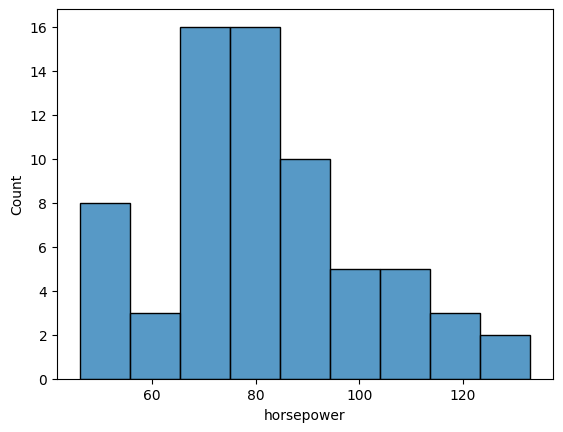

In [7]:
sns.histplot(group1)
plt.show()

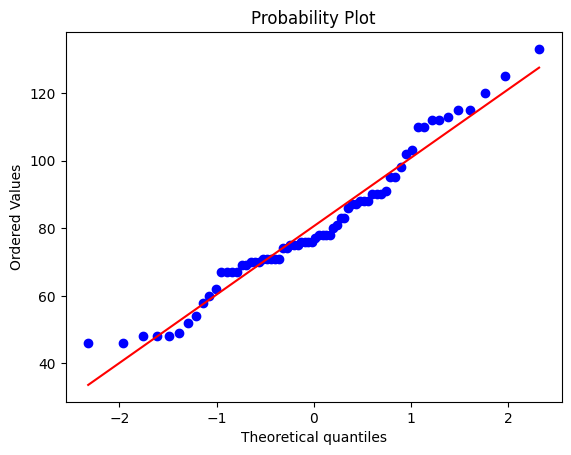

In [8]:
stats.probplot(group1,dist='norm',plot=pylab);

In [9]:
stats.kstest(group2, "norm")

KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(52.0), statistic_sign=np.int8(-1))

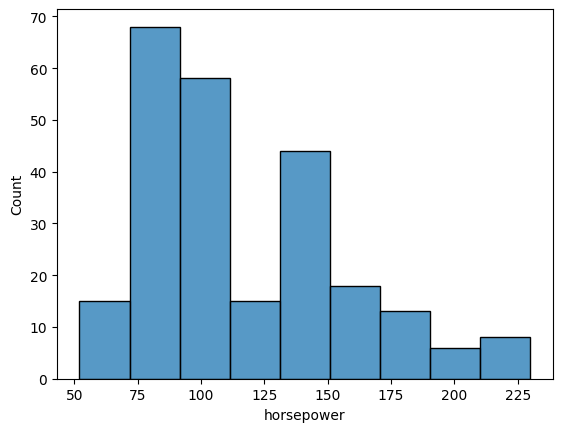

In [10]:
sns.histplot(group2)
plt.show()

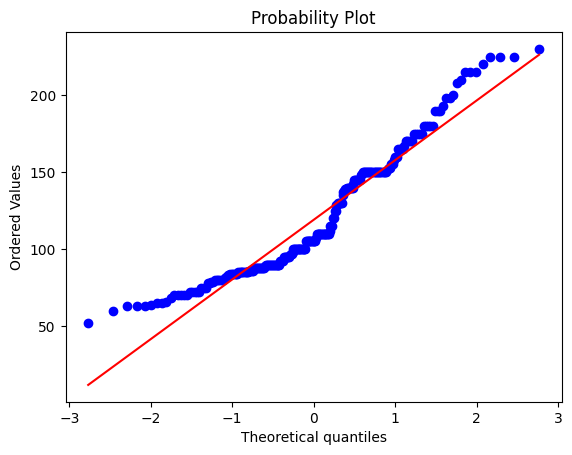

In [11]:
stats.probplot(group2,dist='norm', plot=pylab);

In [12]:
stats.kstest(group3, "norm")

KstestResult(statistic=np.float64(1.0), pvalue=np.float64(0.0), statistic_location=np.float64(52.0), statistic_sign=np.int8(-1))

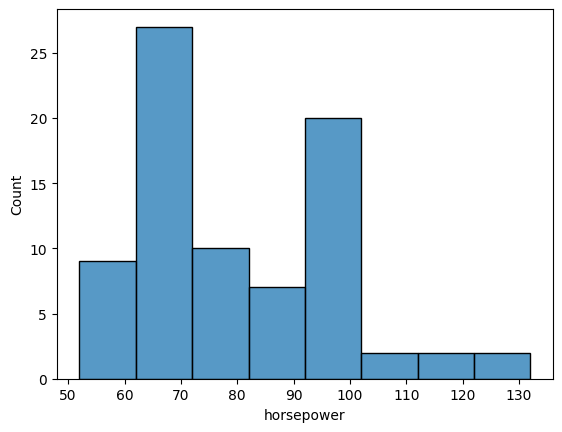

In [13]:
sns.histplot(group3)
plt.show()

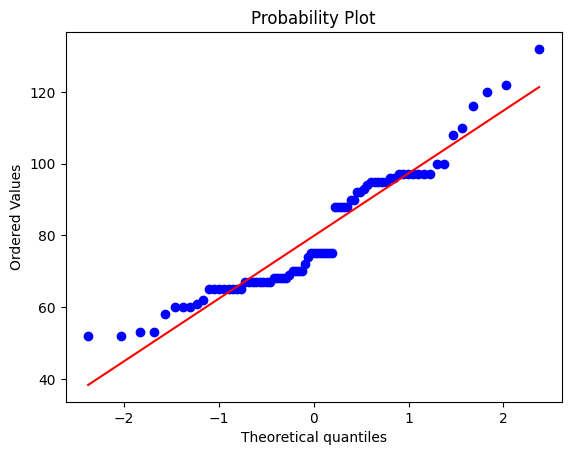

In [14]:
stats.probplot(group3,dist = "norm", plot=pylab);


We reject the Null Hypothesis - the data don't follow normal distribution in any of these three groups.

## 2.Check data for homogeneity of variances:

In [15]:
stats.fligner(group1, group2, group3)

FlignerResult(statistic=np.float64(48.50746046629461), pvalue=np.float64(2.929130993496064e-11))

There is not homogeneity of variances.

## 3.Detecting and removing outliers to normalize the data as any transformation technique does not work:

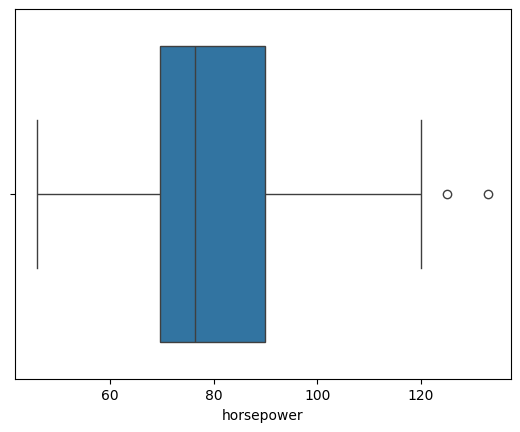

In [16]:
sns.boxplot(x=group1)
plt.show()

In [17]:
group1.describe()

,horsepower
count,68.000000
mean,80.558824
std,20.157871
min,46.000000
25%,69.750000
50%,76.500000
75%,90.000000
max,133.000000


In [18]:
percentile25 = group1.quantile(0.25)
percentile75 = group1.quantile(0.75)
iqr_1 = percentile75 - percentile25

In [19]:
upper_limit = percentile75 + 1.5 * iqr_1
lower_limit = percentile25 - 1.5 * iqr_1

In [20]:
group1_new = group1[group1 < upper_limit]

In [21]:
group1_new = group1[group1 < 120]

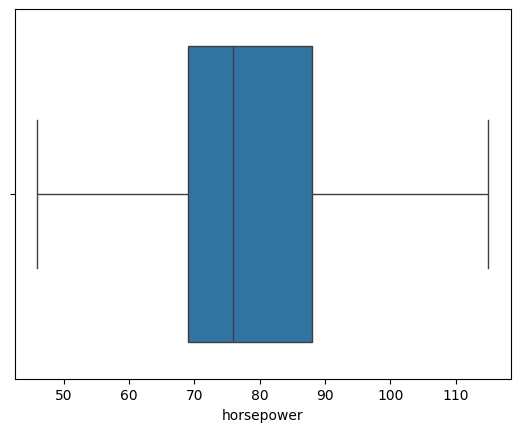

In [22]:
sns.boxplot(x=group1_new)
plt.show()

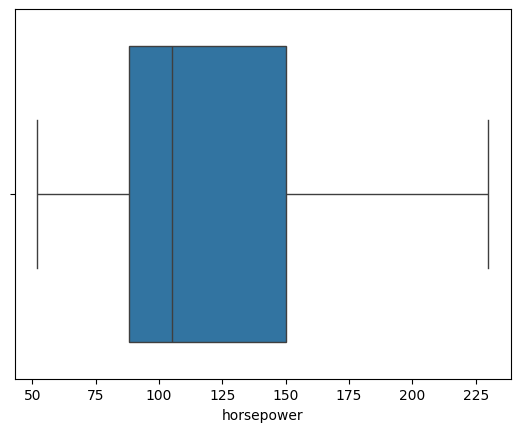

In [23]:
sns.boxplot(x=group2)
plt.show()

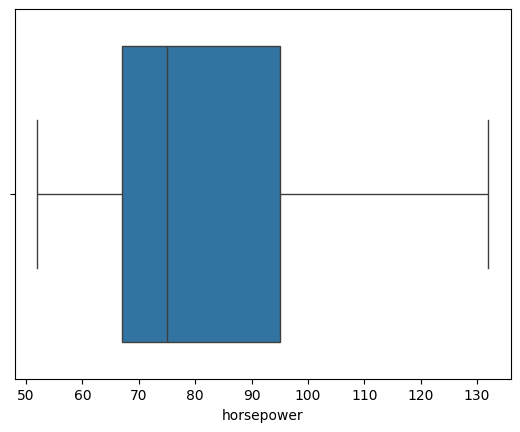

In [24]:
sns.boxplot(x=group3)
plt.show()

In [25]:
group1_transform = np.reciprocal(group1_new)
group2_transform = np.reciprocal(group2)
group3_transform = np.reciprocal(group3)

In [26]:
stats.fligner(group1_transform, group2_transform, group3_transform)

FlignerResult(statistic=np.float64(0.28660847105074566), pvalue=np.float64(0.8664904116249573))

## After deleting outliers and performing a reciprocal transformation, we have homogeneity of variances. Our data is not normal, but have homoscedasticity.

We can perform Kruskal-Wallis H test.

In [27]:
stats.kruskal(group1_transform, group2_transform, group3_transform)

KruskalResult(statistic=np.float64(110.16051856758087), pvalue=np.float64(1.1993538435556213e-24))

At least one of the groups is different because our pvalue is less than 0.05 (alpha).

In [28]:
import scikit_posthocs as sp

ModuleNotFoundError: No module named 'scikit_posthocs'

In [29]:
p_values= sp.posthoc_dunn([group1_transform, group2_transform, group3_transform], p_adjust = 'holm')
p_values

NameError: name 'sp' is not defined

Conclusion: group2 is different from the other groups. While for group1 and group3 we cannot reject the Null hypothesis that they are different.
Only USA cars have statistically different horsepower. We do not have enough evidence to support the hypothesis that cars from Europe and Japan have a statistical difference in horsepower.